## Feature Engineering and Investigation

Import modules required for data analysis and visualistion.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.feature_selection import mutual_info_regression as MIR
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA

Move up one level to the project root to access entire repository. Specify the year to investigate.

In [5]:
#We need to access modules from the project root, so we select this directory.
import os, sys

# Move 1 level up from notebooks/ to project root
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

year = 2024

Import all relevant data - see 'gathering_data' notebook for a detailed breakdown.

In [7]:
from data_import_functions import extract_data_from 

data = extract_data_from(year)
data['prev_NO2'] = data['NO2'].shift(periods=1)
data = data.dropna()
data

Data retrieved from frost.met.no!


,max(air_temperature P1D),mean(wind_speed P1D),sum(duration_of_sunshine P1D),DK1,GER,NL,NO2,UK,Gas Price,Week,Reservoir stores,Storage anomaly,prev_NO2
2024-01-02,-3.585366,9.520,0.00,53.59,53.07,63.06,61.42,64.83,30.572001,1,22.374192,-0.443833,46.63
2024-01-03,-7.492683,10.000,0.00,45.97,45.22,51.43,66.27,81.08,32.794998,1,22.374192,-0.443833,61.42
2024-01-04,-9.385714,6.165,0.00,85.41,85.41,84.68,89.44,93.16,33.410000,1,22.374192,-0.443833,66.27
2024-01-05,-12.385714,4.450,0.00,91.37,91.37,91.22,90.95,96.25,34.550999,1,22.374192,-0.443833,89.44
2024-01-06,-13.278571,2.850,3.20,88.78,88.72,88.64,91.49,95.63,34.550999,1,22.374192,-0.443833,90.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,6.659524,3.080,0.00,95.85,98.63,98.46,30.92,104.19,45.730999,52,26.597146,2.916377,33.99
2024-12-26,6.700000,3.185,0.25,112.89,112.89,112.86,32.97,121.16,45.730999,52,26.597146,2.916377,30.92
2024-12-27,5.423810,1.680,0.00,121.71,121.71,121.43,35.33,128.33,47.730999,52,26.597146,2.916377,32.97
2024-12-28,5.350000,3.320,0.05,122.30,122.64,122.31,30.92,122.70,47.730999,52,26.597146,2.916377,35.33


We start by scaling each of the explanatory variables to a standard normal distribution (i.e. N(0,1)), then we consider the mutual information of each with the target variable (NO2 price) using the sklearn module.

In [9]:
#Separating explanatory variables (X) and target variable (y)
X = data.drop(columns = ['Week'])
y = X.pop('NO2')

#X_scaler = pp.StandardScaler().fit(X)
scaled_X = pd.DataFrame(pp.StandardScaler().fit_transform(X),columns=X.columns)

mut_info = pd.Series(MIR(X, y), name='MI', index=X.columns).sort_values(ascending=False)
print(mut_info)

DK1                              0.655302
GER                              0.447921
NL                               0.315813
UK                               0.307022
prev_NO2                         0.299782
max(air_temperature P1D)         0.285110
Storage anomaly                  0.257280
Gas Price                        0.256669
Reservoir stores                 0.192207
mean(wind_speed P1D)             0.026038
sum(duration_of_sunshine P1D)    0.006172
Name: MI, dtype: float64


Visualising the correlations between explanatory variables by generating a clustermap (derivative of a heatmap) using Seaborn). Variables are clustered into groups that share high correlation. We see that, for example, the prices of neighbouring countries is one such highly-correlated group.

<Figure size 1000x1000 with 0 Axes>

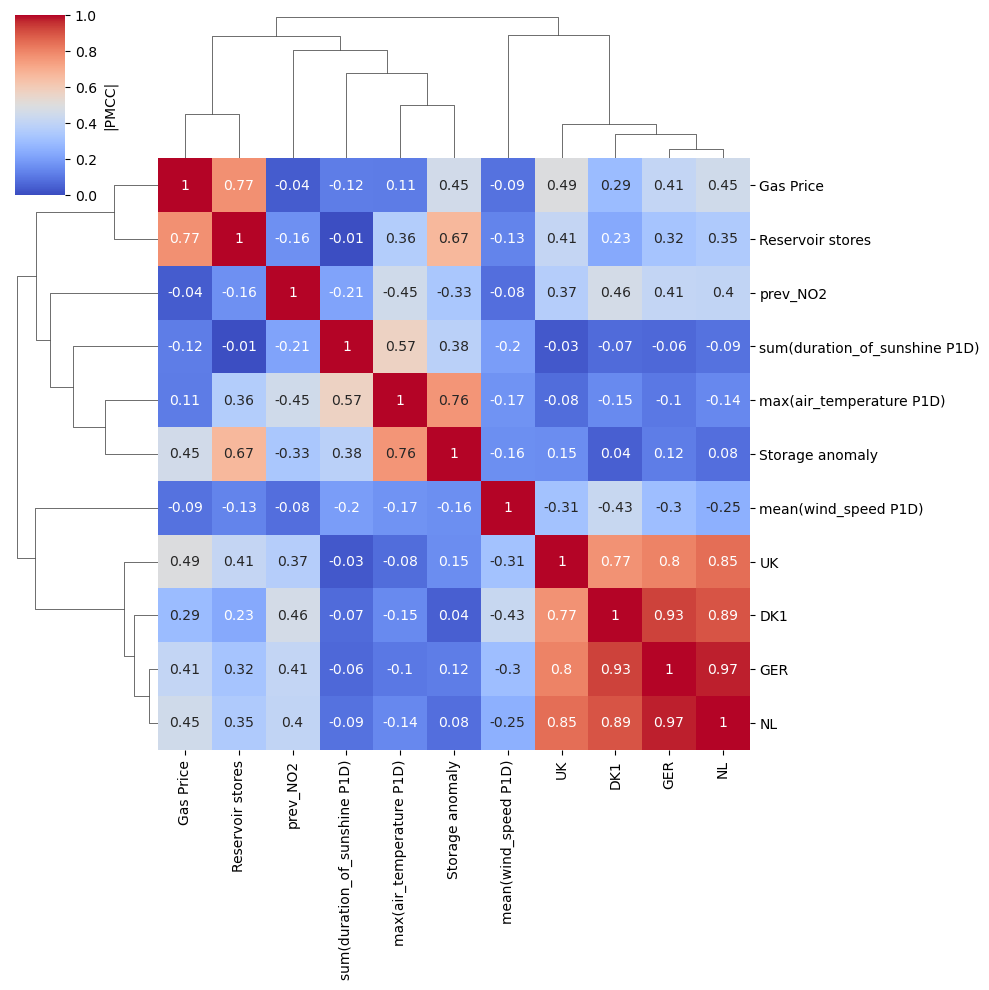

In [11]:
plt.figure(figsize = (10,10))
sns.clustermap(scaled_X.corr().abs(), vmin=0, vmax=1, cmap='coolwarm', cbar_kws={'label':'|PMCC|'}, annot=scaled_X.corr().round(2))

Checking multicollinearity using Variance Inflation Factors (VIFs). 

Essentially, each explanatory variable is regressed against every other. (Find the coefficient of determination, R (which indicates how well the variable is fit with a linear regression of the other variables), and the VIF = 1/(1-R^2)).

VIF reaffirms the collinearity of the power prices of neighbouring regions.

In [13]:
pd.Series([VIF(scaled_X.values, i) for i in range(len(scaled_X.columns))], name='VIF', index=scaled_X.columns)

max(air_temperature P1D)          3.677573
mean(wind_speed P1D)              1.556466
sum(duration_of_sunshine P1D)     1.715631
DK1                              10.677659
GER                              34.873541
NL                               31.298648
UK                                4.350210
Gas Price                         3.144989
Reservoir stores                  3.942322
Storage anomaly                   4.512829
prev_NO2                          1.658650
Name: VIF, dtype: float64

Here is the breakdown of the PCA decomposition (of the standardised explanatory variables).

                               PCA1  PCA2  PCA3  PCA4  PCA5  PCA6  PCA7  PCA8  \
max(air_temperature P1D)      -0.02 -0.52 -0.24  0.14  0.05  0.40 -0.20  0.41   
mean(wind_speed P1D)          -0.19  0.08  0.47  0.83 -0.10  0.07 -0.02 -0.03   
sum(duration_of_sunshine P1D) -0.03 -0.31 -0.56  0.39  0.06 -0.61  0.18 -0.18   
DK1                            0.43  0.13 -0.19  0.00 -0.15  0.22  0.25 -0.11   
GER                            0.45  0.09 -0.09  0.16 -0.22  0.15  0.26  0.03   
NL                             0.45  0.09 -0.03  0.18 -0.23  0.03  0.09  0.04   
UK                             0.43  0.03 -0.02  0.08 -0.05 -0.23 -0.84  0.04   
Gas Price                      0.29 -0.23  0.46 -0.12  0.13 -0.46  0.28  0.56   
Reservoir stores               0.25 -0.37  0.38 -0.12  0.18 -0.03 -0.01 -0.68   
Storage anomaly                0.12 -0.52  0.02  0.09  0.20  0.34  0.06 -0.04   
prev_NO2                       0.19  0.37 -0.11  0.18  0.87  0.10  0.03  0.06   

                           

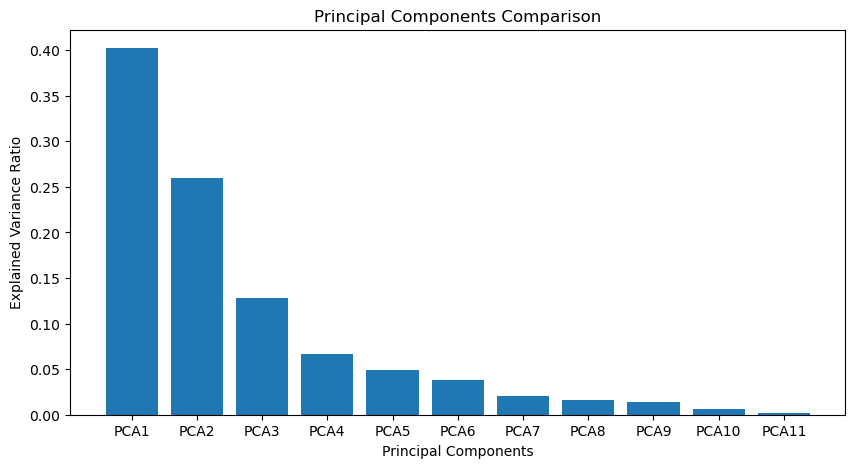

In [15]:
pca = PCA()
X_pca = pca.fit_transform(scaled_X)

pca_headers = [f'PCA{i}' for i in range(1,len(scaled_X.columns)+1)]
pca_breakdown = pd.DataFrame(pca.components_.round(2), index = pca_headers, columns = scaled_X.columns)
pprint(pca_breakdown.T)
plt.figure(figsize=(10,5))
plt.bar(pca_headers, pca.explained_variance_ratio_)
plt.xlabel("Principal Components")  
plt.ylabel("Explained Variance Ratio")  
plt.title("Principal Components Comparison")    
plt.show()

We also consider the mutual information of the new PCA variables and the target variable.

In [17]:
pca_mutual_info = pd.Series(MIR(X_pca, y), index=pca_headers).sort_values(ascending=False)
print(pca_mutual_info)

PCA1     0.478798
PCA2     0.389173
PCA7     0.212930
PCA10    0.150285
PCA8     0.122305
PCA3     0.078808
PCA5     0.066621
PCA9     0.063136
PCA6     0.057192
PCA11    0.034689
PCA4     0.000014
dtype: float64
